In [1]:
from __future__ import print_function

import argparse
import csv
import os
#from selectors import EpollSelector

import numpy as np
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
#from torch.utils.tensorboard import SummaryWriter
import torchvision.datasets as datasets
from torch.utils.data import random_split
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
from utils_c import load_txt
from torch.utils.data import Subset, ConcatDataset, ChainDataset

import time

import models
from utils import progress_bar
from dataset import CIFAR10C, CIFAR100C

%matplotlib inline

In [3]:
mydir = 'cifar100_cifar100C_resnet18'
mycheckpoint = 'ckpt.t7_ResNet18_CIFAR100_CIFAR100C_last'

In [4]:


# Model
# Load checkpoint.
print('==> Resuming from checkpoint..')
assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
checkpoint = torch.load('./checkpoint/' + mydir + '/'+ mycheckpoint)
net = checkpoint['net']
#best_acc = checkpoint['acc']
#start_epoch = checkpoint['epoch'] + 1
rng_state = checkpoint['rng_state']
torch.set_rng_state(rng_state)

==> Resuming from checkpoint..


In [5]:
transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                (0.2023, 0.1994, 0.2010)),
        ])

In [29]:
print('Chose CIFAR100 Dataset..')

testset_1 = datasets.CIFAR100(root='~/data', train=False, download=False,
                        transform=transform_test)
testloader_1 = torch.utils.data.DataLoader(testset_1, batch_size=100,
                                        shuffle=False, num_workers=8)

Chose CIFAR100 Dataset..


In [33]:
my_data_root = 'C:/Users/naama-alon/data'

print('Chose CIFAR100 Corrupted Trainset..')
corruptions = load_txt('./corruptions.txt')

for i, cname in enumerate(corruptions):
    tmp_dataset = CIFAR100C(root=os.path.join(my_data_root, 'CIFAR-100-C'),name=cname,
                                transform=transform_test)
    start= 20000
    stop = 30000
    indices = [i for i in range(start, stop)] # use sevirity 3
    sev3 = Subset(tmp_dataset, indices)
    split_lengths = [int(len(sev3)*0.833), int(len(sev3)*0.167)]
    _, sev3_testset = random_split(sev3, split_lengths)
    if i==0:
        testset_arr = [sev3_testset]
    else:
        testset_arr.append(sev3_testset)

testset_2=  ConcatDataset(testset_arr)

testloader_2 = torch.utils.data.DataLoader(testset_2, batch_size=100,
                                        shuffle=True, num_workers=8)

Chose CIFAR100 Corrupted Trainset..


In [47]:
def load_sample_data():
    ds = testloader.dataset
    input = torch.zeros([64,3,32,32])
    target = torch.zeros([64])
    for i in range(64):
        #inp,tar = ds[i+7000]
        inp,tar = ds[i]
        input[i,:,:,:] = inp
        target[i] = tar
    return input, target

input,target = load_sample_data()

In [39]:
import cs236781.plot as plot

In [48]:
model_output = net(input)

max_out ,ind = torch.max(model_output,1)
device = 'cuda'

false = torch.where(ind.to(device)!=target.to(device))[0].data.cpu().numpy()

#plot.tensors_as_images(input[false][0:5])

import pandas as pd
import numpy as np

target_ = np.int8(target.data.cpu().numpy())
output_ = np.int8(ind.data.cpu().numpy())



classes = np.array(testset_1.classes)
true_class = classes[target_]
out_class = classes[output_]

data = {'gt':  target_[false],
        'true class': true_class[false],
        'output':output_[false],
        'output class': out_class[false]
        }

df = pd.DataFrame(data)
pd.set_option('display.max_rows', df.shape[0]+1)
df.style




,gt,true class,output,output class
0,35,girl,33,forest
1,46,man,11,boy
2,47,maple_tree,40,lamp
3,10,bowl,28,cup
4,24,cockroach,82,sunflower
5,76,skyscraper,16,can
6,81,streetcar,16,can
7,65,rabbit,44,lizard
8,44,lizard,33,forest
9,43,lion,82,sunflower


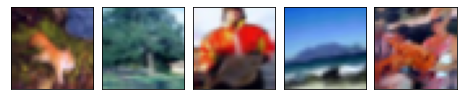

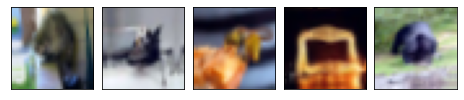

In [45]:
fig , ax = plot.tensors_as_images(input[false][0:5])

fig , ax =plot.tensors_as_images(input[false][5:10])